In [1]:
# Credit Risk Assessment: Model Development
# Notebook 03: Building and Training ML Models

"""
OBJECTIVES:
1. Build baseline model (Logistic Regression)
2. Implement tree-based models (Decision Tree, Random Forest)
3. Train gradient boosting model (XGBoost)
4. Handle class imbalance
5. Evaluate and compare all models
6. Select best model
"""

# ============================================================================
# IMPORTS
# ============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

# Evaluation Metrics
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score,
    roc_curve, precision_recall_curve, auc
)

# Class Imbalance Handling
from imblearn.over_sampling import SMOTE

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')

print("✅ All packages imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"XGBoost version: {xgb.__version__}")

✅ All packages imported successfully!
Pandas version: 2.0.3
XGBoost version: 2.0.0


In [2]:
# ============================================================================
# 1. LOAD PREPROCESSED DATA
# ============================================================================
print("\n" + "="*80)
print("SECTION 1: DATA LOADING")
print("="*80)

# Load train, validation, test sets
X_train = pd.read_csv('../data/processed/X_train.csv')
X_val = pd.read_csv('../data/processed/X_val.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

y_train = pd.read_csv('../data/processed/y_train.csv')['target']
y_val = pd.read_csv('../data/processed/y_val.csv')['target']
y_test = pd.read_csv('../data/processed/y_test.csv')['target']

print("✓ Data loaded successfully!")
print(f"\nTraining set:   X={X_train.shape}, y={y_train.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}")
print(f"Test set:       X={X_test.shape}, y={y_test.shape}")

print("\nClass distribution:")
print(f"  Training:   Good={sum(y_train==0)}, Bad={sum(y_train==1)}")
print(f"  Validation: Good={sum(y_val==0)}, Bad={sum(y_val==1)}")
print(f"  Test:       Good={sum(y_test==0)}, Bad={sum(y_test==1)}")

# Calculate class imbalance ratio
imbalance_ratio = sum(y_train==0) / sum(y_train==1)
print(f"\n⚠️ Class Imbalance Ratio: {imbalance_ratio:.2f}:1")


SECTION 1: DATA LOADING
✓ Data loaded successfully!

Training set:   X=(700, 20), y=(700,)
Validation set: X=(150, 20), y=(150,)
Test set:       X=(150, 20), y=(150,)

Class distribution:
  Training:   Good=490, Bad=210
  Validation: Good=105, Bad=45
  Test:       Good=105, Bad=45

⚠️ Class Imbalance Ratio: 2.33:1


In [3]:
# ============================================================================
# 2. EVALUATION HELPER FUNCTIONS
# ============================================================================
print("\n" + "="*80)
print("SECTION 2: SETTING UP EVALUATION FUNCTIONS")
print("="*80)

def evaluate_model(y_true, y_pred, y_pred_proba=None, model_name="Model"):
    """
    Comprehensive model evaluation
    """
    print(f"\n{'='*60}")
    print(f"{model_name} - PERFORMANCE METRICS")
    print(f"{'='*60}")
    
    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\nAccuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f} (of predicted BAD, how many are actually BAD)")
    print(f"Recall:    {recall:.4f} (of actual BAD, how many did we catch)")
    print(f"F1-Score:  {f1:.4f} (balance of precision and recall)")
    
    # AUC-ROC if probabilities provided
    if y_pred_proba is not None:
        auc_roc = roc_auc_score(y_true, y_pred_proba)
        print(f"AUC-ROC:   {auc_roc:.4f} (overall discriminative ability)")
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"                 Predicted")
    print(f"                Good  Bad")
    print(f"Actual Good    {cm[0,0]:5d} {cm[0,1]:5d}")
    print(f"       Bad     {cm[1,0]:5d} {cm[1,1]:5d}")
    
    # Return metrics dictionary
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc if y_pred_proba is not None else None,
        'confusion_matrix': cm
    }
    
    return metrics

def plot_confusion_matrix(cm, model_name):
    """
    Plot confusion matrix heatmap
    """
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Good (0)', 'Bad (1)'],
                yticklabels=['Good (0)', 'Bad (1)'],
                cbar_kws={'label': 'Count'})
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=12)
    plt.xlabel('Predicted', fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_roc_curve(y_true, y_pred_proba, model_name):
    """
    Plot ROC curve
    """
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'{model_name} - ROC Curve', fontsize=14, fontweight='bold')
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

print("✓ Evaluation functions created!")


SECTION 2: SETTING UP EVALUATION FUNCTIONS
✓ Evaluation functions created!



SECTION 3: LOGISTIC REGRESSION (BASELINE)

Training Logistic Regression...
✓ Model trained!

Logistic Regression - PERFORMANCE METRICS

Accuracy:  0.7933
Precision: 0.7333 (of predicted BAD, how many are actually BAD)
Recall:    0.4889 (of actual BAD, how many did we catch)
F1-Score:  0.5867 (balance of precision and recall)
AUC-ROC:   0.8080 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good       97     8
       Bad        23    22


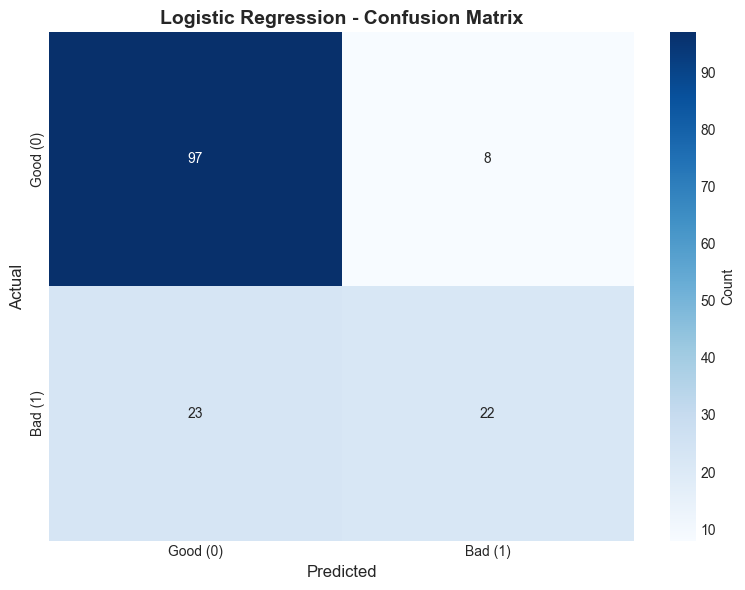

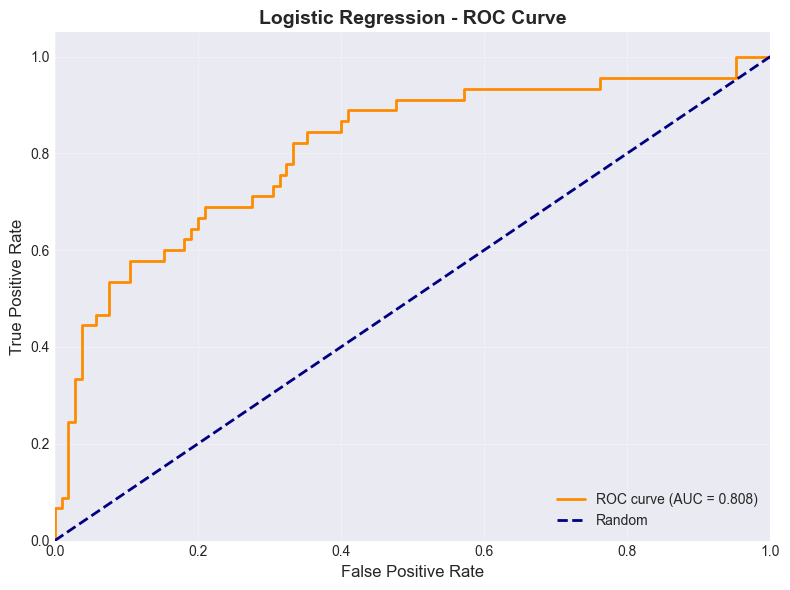


✓ Model saved!


In [4]:
# ============================================================================
# 3. BASELINE MODEL - LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("SECTION 3: LOGISTIC REGRESSION (BASELINE)")
print("="*80)

print("\nTraining Logistic Regression...")

# Create and train model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

print("✓ Model trained!")

# Predictions on validation set
y_val_pred_lr = lr_model.predict(X_val)
y_val_pred_proba_lr = lr_model.predict_proba(X_val)[:, 1]

# Evaluate
lr_metrics = evaluate_model(y_val, y_val_pred_lr, y_val_pred_proba_lr, 
                            "Logistic Regression")

# Visualizations
plot_confusion_matrix(lr_metrics['confusion_matrix'], "Logistic Regression")
plot_roc_curve(y_val, y_val_pred_proba_lr, "Logistic Regression")

# Save model
joblib.dump(lr_model, '../models/logistic_regression.pkl')
print("\n✓ Model saved!")


SECTION 4: DECISION TREE

Training Decision Tree...
✓ Model trained!

Decision Tree - PERFORMANCE METRICS

Accuracy:  0.6800
Precision: 0.4571 (of predicted BAD, how many are actually BAD)
Recall:    0.3556 (of actual BAD, how many did we catch)
F1-Score:  0.4000 (balance of precision and recall)
AUC-ROC:   0.6584 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good       86    19
       Bad        29    16


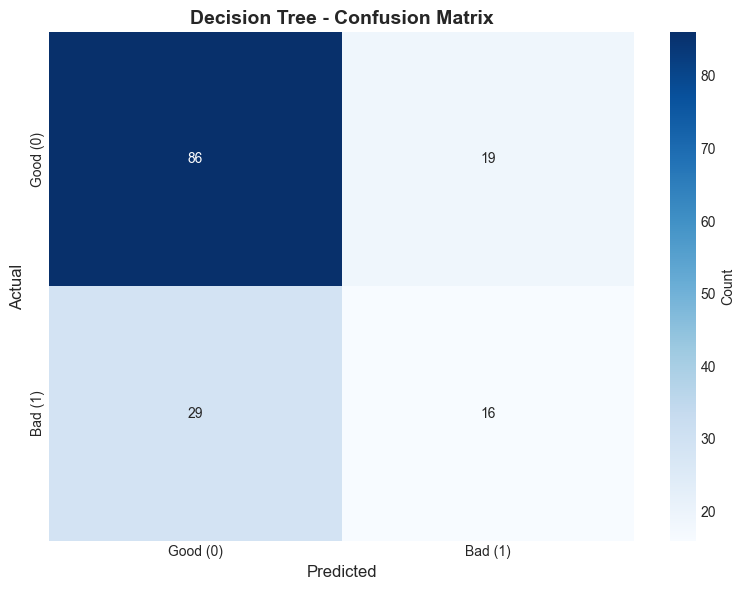

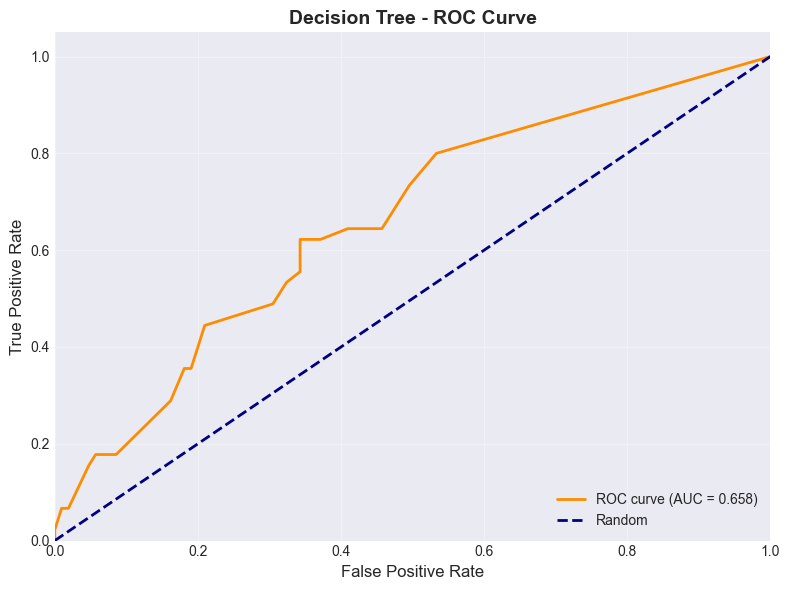


✓ Model saved!


In [5]:
# ============================================================================
# 4. DECISION TREE MODEL
# ============================================================================
print("\n" + "="*80)
print("SECTION 4: DECISION TREE")
print("="*80)

print("\nTraining Decision Tree...")

# Create and train model
dt_model = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=20,
    min_samples_leaf=10,
    random_state=42
)
dt_model.fit(X_train, y_train)

print("✓ Model trained!")

# Predictions
y_val_pred_dt = dt_model.predict(X_val)
y_val_pred_proba_dt = dt_model.predict_proba(X_val)[:, 1]

# Evaluate
dt_metrics = evaluate_model(y_val, y_val_pred_dt, y_val_pred_proba_dt, 
                            "Decision Tree")

# Visualizations
plot_confusion_matrix(dt_metrics['confusion_matrix'], "Decision Tree")
plot_roc_curve(y_val, y_val_pred_proba_dt, "Decision Tree")

# Save model
joblib.dump(dt_model, '../models/decision_tree.pkl')
print("\n✓ Model saved!")


SECTION 5: RANDOM FOREST

Training Random Forest...
✓ Model trained!

Random Forest - PERFORMANCE METRICS

Accuracy:  0.7800
Precision: 0.8333 (of predicted BAD, how many are actually BAD)
Recall:    0.3333 (of actual BAD, how many did we catch)
F1-Score:  0.4762 (balance of precision and recall)
AUC-ROC:   0.8269 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good      102     3
       Bad        30    15


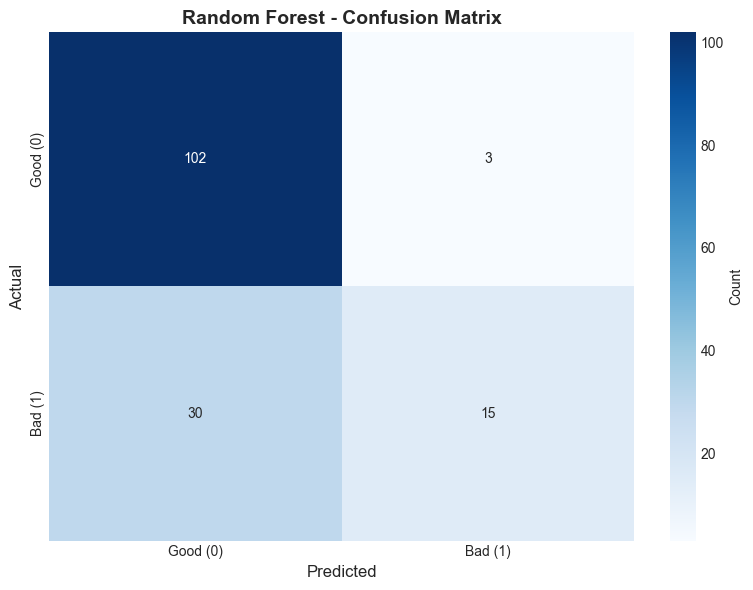

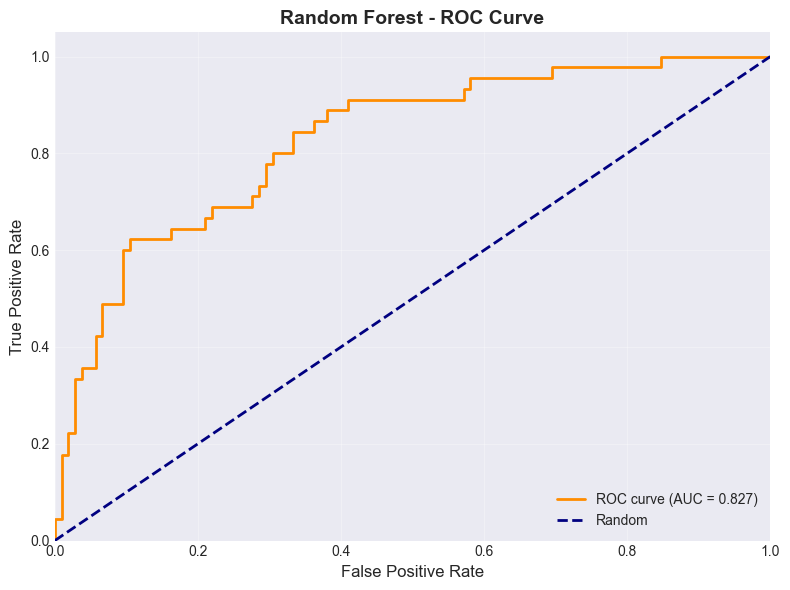


TOP 10 MOST IMPORTANT FEATURES
                   feature  importance
0          checking_status    0.176634
4            credit_amount    0.123583
1                 duration    0.113409
12                     age    0.076551
2           credit_history    0.069342
3                  purpose    0.060361
5           savings_status    0.054356
6               employment    0.052079
11      property_magnitude    0.050331
7   installment_commitment    0.044388


<Figure size 1000x600 with 0 Axes>

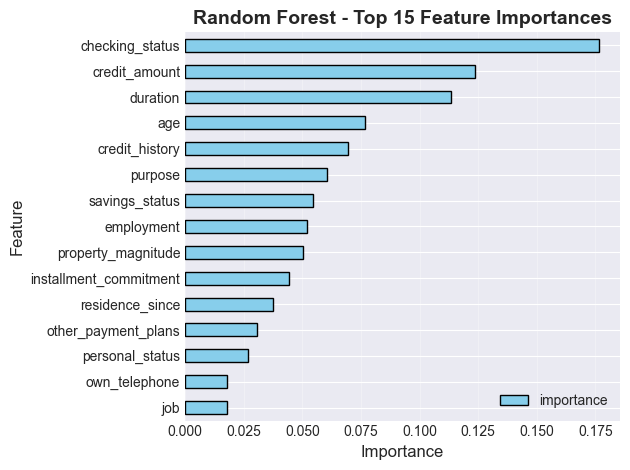


✓ Model saved!


In [6]:
# ============================================================================
# 5. RANDOM FOREST MODEL
# ============================================================================
print("\n" + "="*80)
print("SECTION 5: RANDOM FOREST")
print("="*80)

print("\nTraining Random Forest...")

# Create and train model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1  # Use all CPU cores
)
rf_model.fit(X_train, y_train)

print("✓ Model trained!")

# Predictions
y_val_pred_rf = rf_model.predict(X_val)
y_val_pred_proba_rf = rf_model.predict_proba(X_val)[:, 1]

# Evaluate
rf_metrics = evaluate_model(y_val, y_val_pred_rf, y_val_pred_proba_rf, 
                            "Random Forest")

# Visualizations
plot_confusion_matrix(rf_metrics['confusion_matrix'], "Random Forest")
plot_roc_curve(y_val, y_val_pred_proba_rf, "Random Forest")

# Feature Importance
print("\n" + "="*60)
print("TOP 10 MOST IMPORTANT FEATURES")
print("="*60)
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(feature_importance.head(10))

# Plot feature importance
plt.figure(figsize=(10, 6))
feature_importance.head(15).plot(x='feature', y='importance', kind='barh', 
                                  color='skyblue', edgecolor='black')
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Random Forest - Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

# Save model
joblib.dump(rf_model, '../models/random_forest.pkl')
print("\n✓ Model saved!")


SECTION 6: XGBOOST (GRADIENT BOOSTING)

Training XGBoost...
✓ Model trained!

XGBoost - PERFORMANCE METRICS

Accuracy:  0.7467
Precision: 0.5897 (of predicted BAD, how many are actually BAD)
Recall:    0.5111 (of actual BAD, how many did we catch)
F1-Score:  0.5476 (balance of precision and recall)
AUC-ROC:   0.7714 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good       89    16
       Bad        22    23


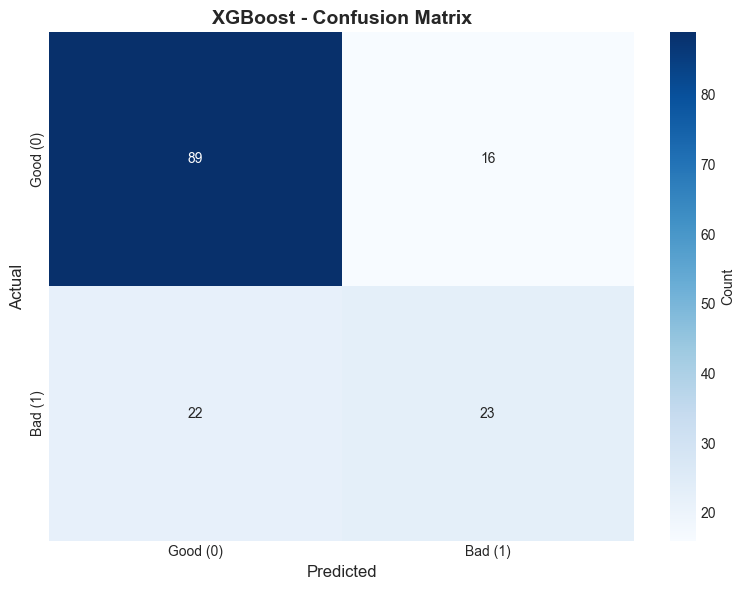

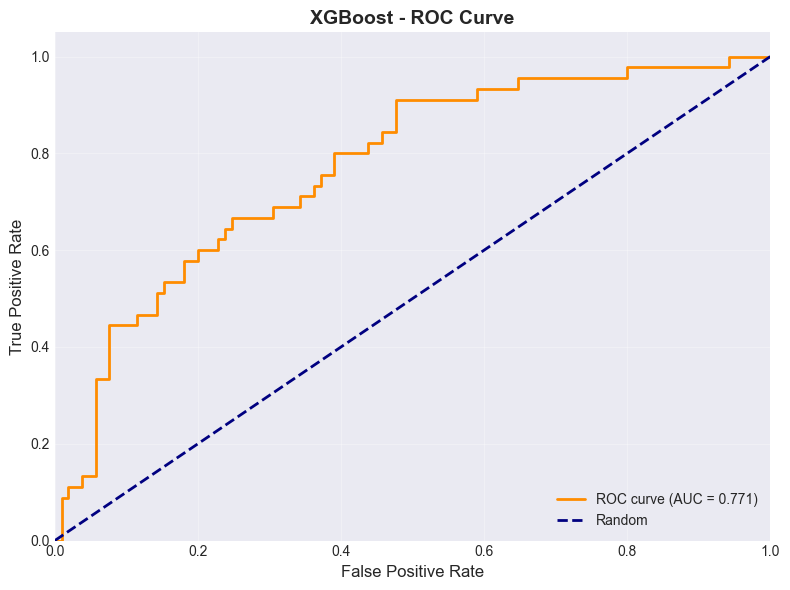


XGBOOST - TOP 10 MOST IMPORTANT FEATURES
                feature  importance
0       checking_status    0.154734
2        credit_history    0.062693
1              duration    0.060511
13  other_payment_plans    0.054261
3               purpose    0.053367
5        savings_status    0.051075
11   property_magnitude    0.049649
9         other_parties    0.046628
4         credit_amount    0.045326
18        own_telephone    0.042472

✓ Model saved!


In [7]:
# ============================================================================
# 6. XGBOOST MODEL
# ============================================================================
print("\n" + "="*80)
print("SECTION 6: XGBOOST (GRADIENT BOOSTING)")
print("="*80)

print("\nTraining XGBoost...")

# Create and train model
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=imbalance_ratio,  # Handle class imbalance
    random_state=42,
    eval_metric='logloss'
)

xgb_model.fit(X_train, y_train)

print("✓ Model trained!")

# Predictions
y_val_pred_xgb = xgb_model.predict(X_val)
y_val_pred_proba_xgb = xgb_model.predict_proba(X_val)[:, 1]

# Evaluate
xgb_metrics = evaluate_model(y_val, y_val_pred_xgb, y_val_pred_proba_xgb, 
                             "XGBoost")

# Visualizations
plot_confusion_matrix(xgb_metrics['confusion_matrix'], "XGBoost")
plot_roc_curve(y_val, y_val_pred_proba_xgb, "XGBoost")

# Feature Importance
print("\n" + "="*60)
print("XGBOOST - TOP 10 MOST IMPORTANT FEATURES")
print("="*60)
xgb_feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print(xgb_feature_importance.head(10))

# Save model
joblib.dump(xgb_model, '../models/xgboost.pkl')
print("\n✓ Model saved!")


SECTION 7: MODEL COMPARISON

MODEL PERFORMANCE COMPARISON
              Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
Logistic Regression  0.793333   0.733333 0.488889  0.586667 0.808042
      Decision Tree  0.680000   0.457143 0.355556  0.400000 0.658413
      Random Forest  0.780000   0.833333 0.333333  0.476190 0.826878
            XGBoost  0.746667   0.589744 0.511111  0.547619 0.771429

🏆 BEST MODEL: Random Forest
   AUC-ROC: 0.8269


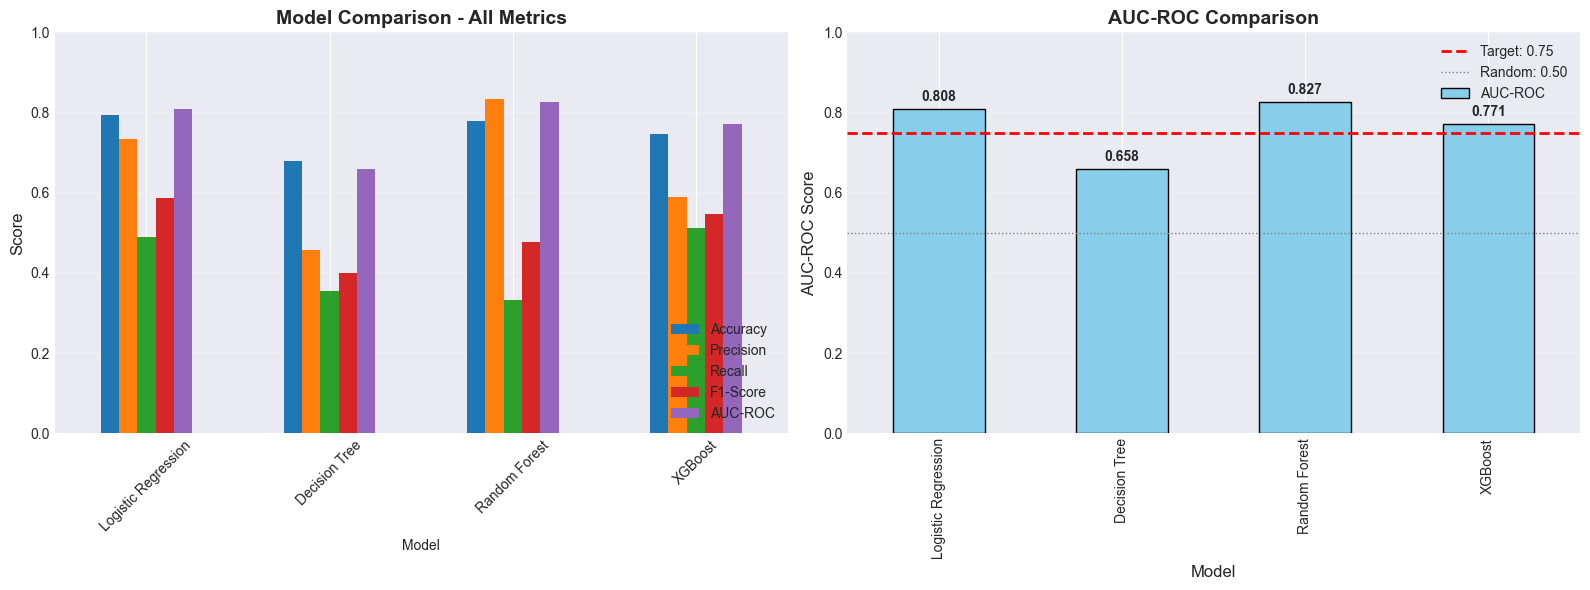


✓ Comparison saved to reports/model_comparison.csv


In [8]:
# ============================================================================
# 7. MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("SECTION 7: MODEL COMPARISON")
print("="*80)

# Create comparison dataframe
comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'Accuracy': [lr_metrics['accuracy'], dt_metrics['accuracy'], 
                 rf_metrics['accuracy'], xgb_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], dt_metrics['precision'], 
                  rf_metrics['precision'], xgb_metrics['precision']],
    'Recall': [lr_metrics['recall'], dt_metrics['recall'], 
               rf_metrics['recall'], xgb_metrics['recall']],
    'F1-Score': [lr_metrics['f1'], dt_metrics['f1'], 
                 rf_metrics['f1'], xgb_metrics['f1']],
    'AUC-ROC': [lr_metrics['auc_roc'], dt_metrics['auc_roc'], 
                rf_metrics['auc_roc'], xgb_metrics['auc_roc']]
})

print("\n" + "="*80)
print("MODEL PERFORMANCE COMPARISON")
print("="*80)
print(comparison.to_string(index=False))

# Find best model
best_model_idx = comparison['AUC-ROC'].idxmax()
best_model_name = comparison.loc[best_model_idx, 'Model']
best_auc = comparison.loc[best_model_idx, 'AUC-ROC']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   AUC-ROC: {best_auc:.4f}")

## Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot of all metrics
comparison.set_index('Model')[['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']].plot(
    kind='bar', ax=axes[0], rot=45, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
)
axes[0].set_title('Model Comparison - All Metrics', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_ylim([0, 1])
axes[0].legend(loc='lower right')
axes[0].grid(axis='y', alpha=0.3)

# AUC-ROC comparison - FIXED Y-AXIS
comparison.plot(x='Model', y='AUC-ROC', kind='bar', ax=axes[1], 
                color='skyblue', edgecolor='black', legend=False)
axes[1].set_title('AUC-ROC Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('AUC-ROC Score', fontsize=12)
axes[1].set_xlabel('Model', fontsize=12)
axes[1].set_ylim([0, 1.0])  # Changed from [0.7, 0.9] to [0, 1.0]
axes[1].axhline(y=0.75, color='red', linestyle='--', linewidth=2, label='Target: 0.75')
axes[1].axhline(y=0.5, color='gray', linestyle=':', linewidth=1, label='Random: 0.50')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

for i, v in enumerate(comparison['AUC-ROC']):
    axes[1].text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

# Save comparison
comparison.to_csv('../reports/model_comparison.csv', index=False)
print("\n✓ Comparison saved to reports/model_comparison.csv")

In [9]:
# ============================================================================
# 8. HANDLING CLASS IMBALANCE WITH SMOTE
# ============================================================================
print("\n" + "="*80)
print("SECTION 8: IMPROVING WITH SMOTE")
print("="*80)

print("\nApplying SMOTE to balance training data...")

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print(f"✓ SMOTE applied!")
print(f"\nOriginal training set: {len(y_train)} samples")
print(f"  Good: {sum(y_train==0)}, Bad: {sum(y_train==1)}")
print(f"\nAfter SMOTE: {len(y_train_smote)} samples")
print(f"  Good: {sum(y_train_smote==0)}, Bad: {sum(y_train_smote==1)}")
print(f"  Now balanced! ✓")


SECTION 8: IMPROVING WITH SMOTE

Applying SMOTE to balance training data...
✓ SMOTE applied!

Original training set: 700 samples
  Good: 490, Bad: 210

After SMOTE: 980 samples
  Good: 490, Bad: 490
  Now balanced! ✓



SECTION 9: RANDOM FOREST + SMOTE

Training Random Forest on SMOTE-balanced data...
✓ Model trained!

Random Forest + SMOTE - PERFORMANCE METRICS

Accuracy:  0.7200
Precision: 0.5405 (of predicted BAD, how many are actually BAD)
Recall:    0.4444 (of actual BAD, how many did we catch)
F1-Score:  0.4878 (balance of precision and recall)
AUC-ROC:   0.7805 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good       88    17
       Bad        25    20


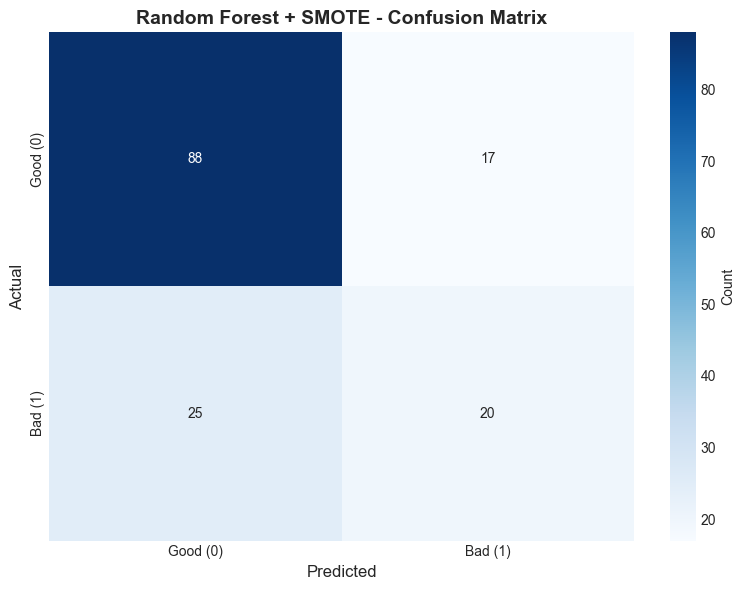

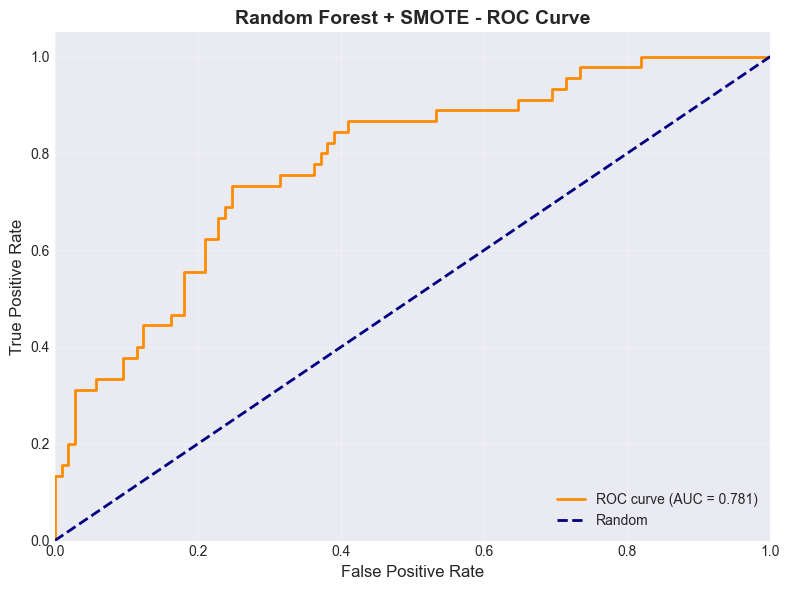


✓ Model saved!


In [10]:
# ============================================================================
# 9. RANDOM FOREST WITH SMOTE
# ============================================================================
print("\n" + "="*80)
print("SECTION 9: RANDOM FOREST + SMOTE")
print("="*80)

print("\nTraining Random Forest on SMOTE-balanced data...")

# Train model
rf_smote_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_smote_model.fit(X_train_smote, y_train_smote)

print("✓ Model trained!")

# Predictions
y_val_pred_rf_smote = rf_smote_model.predict(X_val)
y_val_pred_proba_rf_smote = rf_smote_model.predict_proba(X_val)[:, 1]

# Evaluate
rf_smote_metrics = evaluate_model(y_val, y_val_pred_rf_smote, 
                                  y_val_pred_proba_rf_smote, 
                                  "Random Forest + SMOTE")

# Visualizations
plot_confusion_matrix(rf_smote_metrics['confusion_matrix'], "Random Forest + SMOTE")
plot_roc_curve(y_val, y_val_pred_proba_rf_smote, "Random Forest + SMOTE")

# Save model
joblib.dump(rf_smote_model, '../models/random_forest_smote.pkl')
print("\n✓ Model saved!")


SECTION 9: RANDOM FOREST + SMOTE

Training Random Forest on SMOTE-balanced data...
✓ Model trained!

Random Forest + SMOTE - PERFORMANCE METRICS

Accuracy:  0.7200
Precision: 0.5405 (of predicted BAD, how many are actually BAD)
Recall:    0.4444 (of actual BAD, how many did we catch)
F1-Score:  0.4878 (balance of precision and recall)
AUC-ROC:   0.7805 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good       88    17
       Bad        25    20


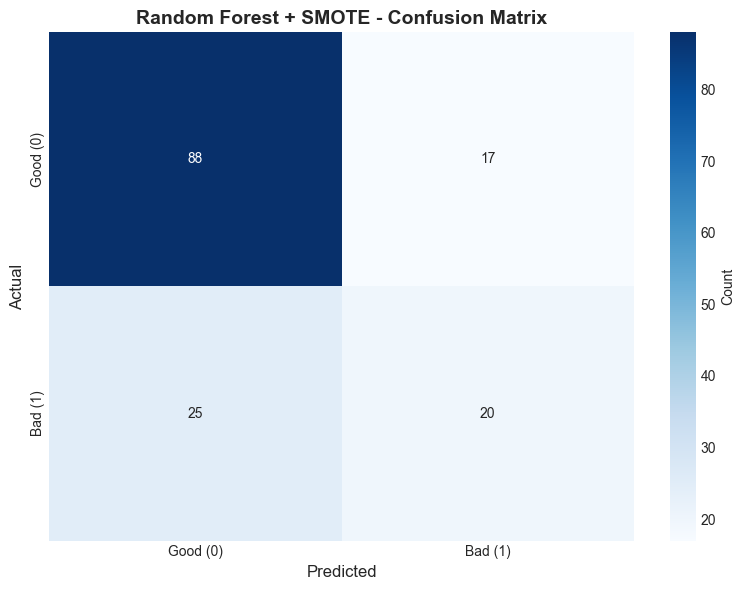

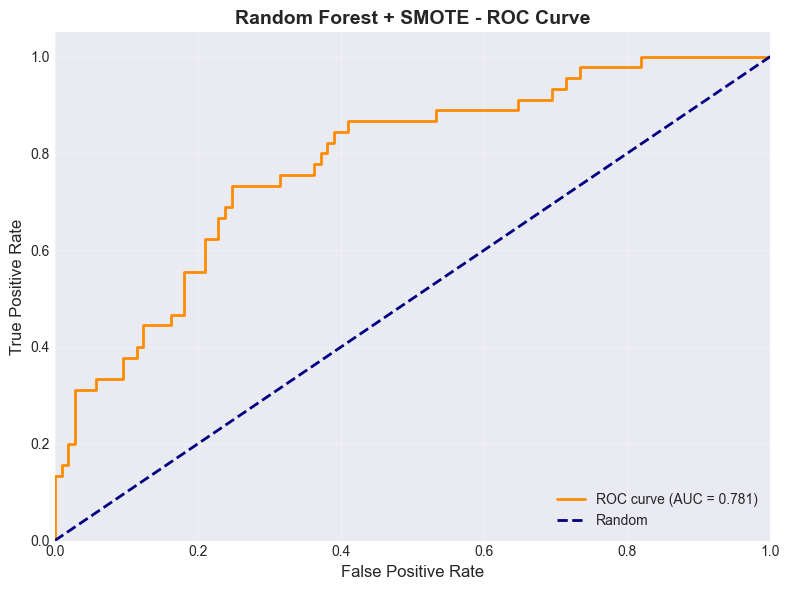


✓ Model saved!


In [11]:
# ============================================================================
# 9. RANDOM FOREST WITH SMOTE
# ============================================================================
print("\n" + "="*80)
print("SECTION 9: RANDOM FOREST + SMOTE")
print("="*80)

print("\nTraining Random Forest on SMOTE-balanced data...")

# Train model
rf_smote_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=15,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)
rf_smote_model.fit(X_train_smote, y_train_smote)

print("✓ Model trained!")

# Predictions
y_val_pred_rf_smote = rf_smote_model.predict(X_val)
y_val_pred_proba_rf_smote = rf_smote_model.predict_proba(X_val)[:, 1]

# Evaluate
rf_smote_metrics = evaluate_model(y_val, y_val_pred_rf_smote, 
                                  y_val_pred_proba_rf_smote, 
                                  "Random Forest + SMOTE")

# Visualizations
plot_confusion_matrix(rf_smote_metrics['confusion_matrix'], "Random Forest + SMOTE")
plot_roc_curve(y_val, y_val_pred_proba_rf_smote, "Random Forest + SMOTE")

# Save model
joblib.dump(rf_smote_model, '../models/random_forest_smote.pkl')
print("\n✓ Model saved!")


SECTION 10: XGBOOST + SMOTE

Training XGBoost on SMOTE-balanced data...
✓ Model trained!

XGBoost + SMOTE - PERFORMANCE METRICS

Accuracy:  0.6933
Precision: 0.4828 (of predicted BAD, how many are actually BAD)
Recall:    0.3111 (of actual BAD, how many did we catch)
F1-Score:  0.3784 (balance of precision and recall)
AUC-ROC:   0.7395 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good       90    15
       Bad        31    14


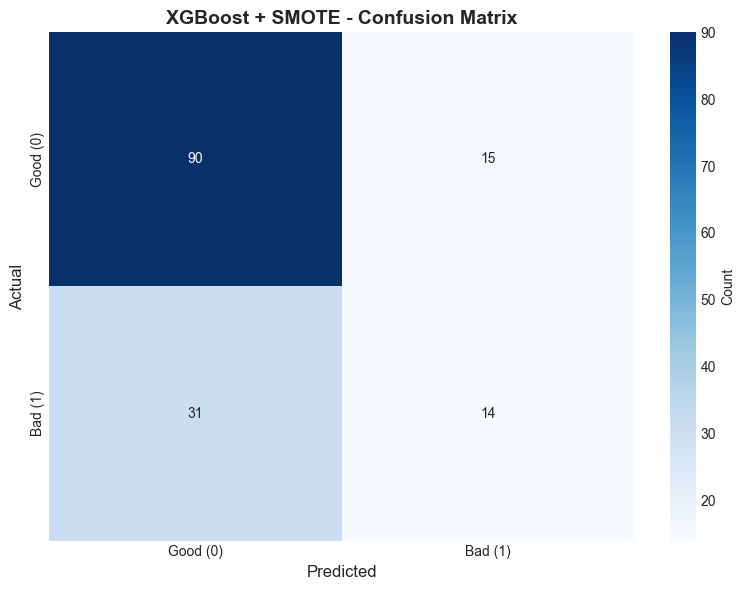

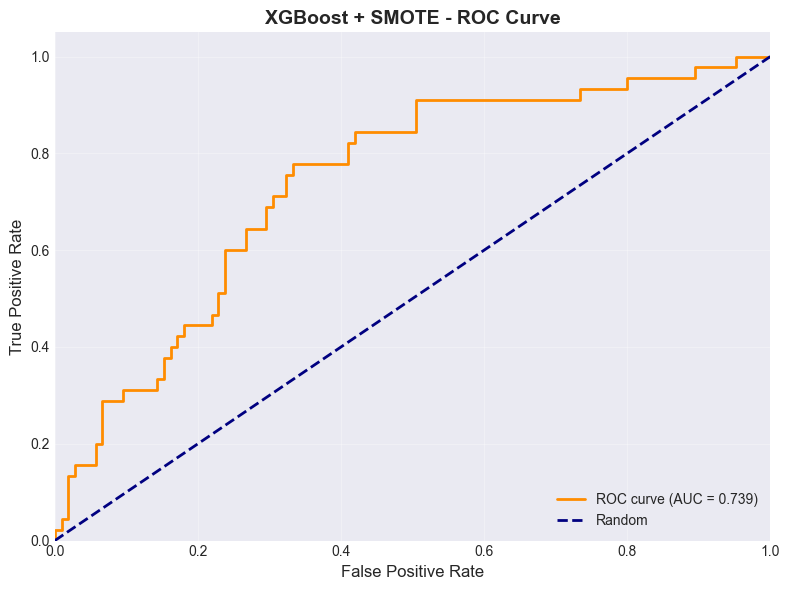


✓ Model saved!


In [12]:
# ============================================================================
# 10. XGBOOST WITH SMOTE
# ============================================================================
print("\n" + "="*80)
print("SECTION 10: XGBOOST + SMOTE")
print("="*80)

print("\nTraining XGBoost on SMOTE-balanced data...")

# Train model
xgb_smote_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss'
)
xgb_smote_model.fit(X_train_smote, y_train_smote)

print("✓ Model trained!")

# Predictions
y_val_pred_xgb_smote = xgb_smote_model.predict(X_val)
y_val_pred_proba_xgb_smote = xgb_smote_model.predict_proba(X_val)[:, 1]

# Evaluate
xgb_smote_metrics = evaluate_model(y_val, y_val_pred_xgb_smote, 
                                   y_val_pred_proba_xgb_smote, 
                                   "XGBoost + SMOTE")

# Visualizations
plot_confusion_matrix(xgb_smote_metrics['confusion_matrix'], "XGBoost + SMOTE")
plot_roc_curve(y_val, y_val_pred_proba_xgb_smote, "XGBoost + SMOTE")

# Save model
joblib.dump(xgb_smote_model, '../models/xgboost_smote.pkl')
print("\n✓ Model saved!")


SECTION 11: FINAL MODEL COMPARISON

FINAL MODEL PERFORMANCE COMPARISON
                Model  Accuracy  Precision   Recall  F1-Score  AUC-ROC
  Logistic Regression  0.793333   0.733333 0.488889  0.586667 0.808042
        Decision Tree  0.680000   0.457143 0.355556  0.400000 0.658413
        Random Forest  0.780000   0.833333 0.333333  0.476190 0.826878
              XGBoost  0.746667   0.589744 0.511111  0.547619 0.771429
Random Forest + SMOTE  0.720000   0.540541 0.444444  0.487805 0.780529
      XGBoost + SMOTE  0.693333   0.482759 0.311111  0.378378 0.739471

🏆 BEST MODEL OVERALL: Random Forest
   AUC-ROC: 0.8269
   Precision: 0.8333
   Recall: 0.3333
   F1-Score: 0.4762


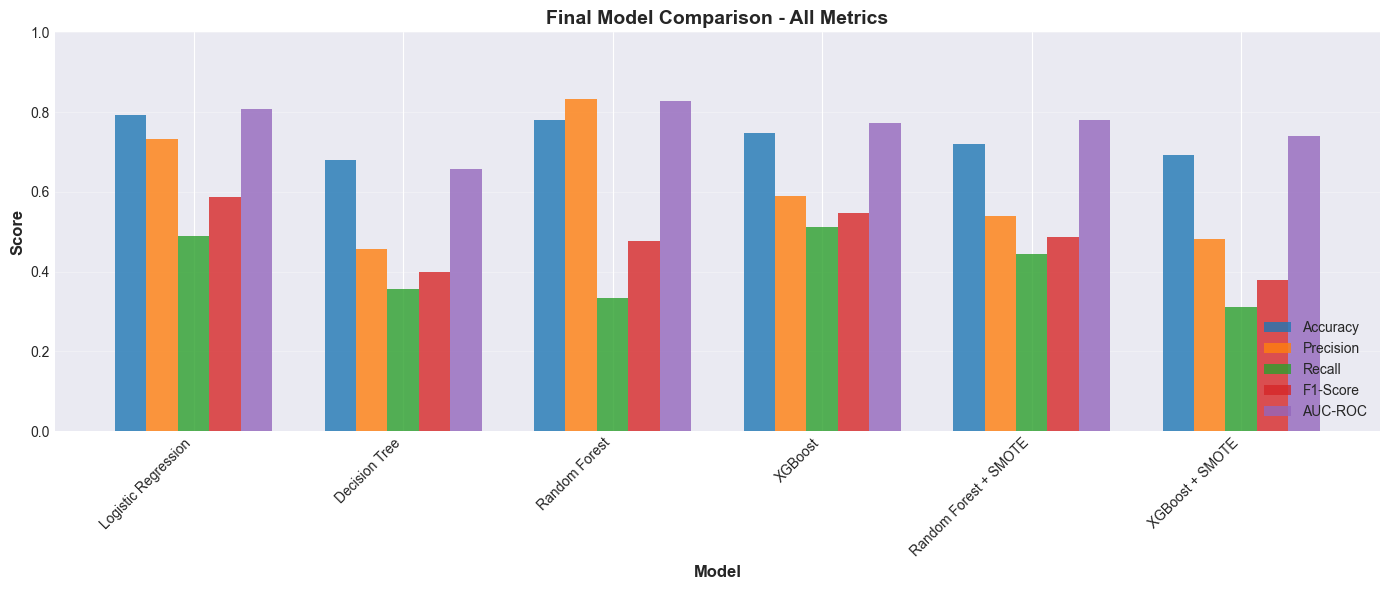


✓ Final comparison saved!


In [13]:
# ============================================================================
# 11. FINAL MODEL COMPARISON (WITH SMOTE)
# ============================================================================
print("\n" + "="*80)
print("SECTION 11: FINAL MODEL COMPARISON")
print("="*80)

# Extended comparison
final_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Random Forest', 
              'XGBoost', 'Random Forest + SMOTE', 'XGBoost + SMOTE'],
    'Accuracy': [lr_metrics['accuracy'], dt_metrics['accuracy'], 
                 rf_metrics['accuracy'], xgb_metrics['accuracy'],
                 rf_smote_metrics['accuracy'], xgb_smote_metrics['accuracy']],
    'Precision': [lr_metrics['precision'], dt_metrics['precision'], 
                  rf_metrics['precision'], xgb_metrics['precision'],
                  rf_smote_metrics['precision'], xgb_smote_metrics['precision']],
    'Recall': [lr_metrics['recall'], dt_metrics['recall'], 
               rf_metrics['recall'], xgb_metrics['recall'],
               rf_smote_metrics['recall'], xgb_smote_metrics['recall']],
    'F1-Score': [lr_metrics['f1'], dt_metrics['f1'], 
                 rf_metrics['f1'], xgb_metrics['f1'],
                 rf_smote_metrics['f1'], xgb_smote_metrics['f1']],
    'AUC-ROC': [lr_metrics['auc_roc'], dt_metrics['auc_roc'], 
                rf_metrics['auc_roc'], xgb_metrics['auc_roc'],
                rf_smote_metrics['auc_roc'], xgb_smote_metrics['auc_roc']]
})

print("\n" + "="*90)
print("FINAL MODEL PERFORMANCE COMPARISON")
print("="*90)
print(final_comparison.to_string(index=False))

# Find overall best model
best_idx = final_comparison['AUC-ROC'].idxmax()
best_name = final_comparison.loc[best_idx, 'Model']
best_auc = final_comparison.loc[best_idx, 'AUC-ROC']

print(f"\n🏆 BEST MODEL OVERALL: {best_name}")
print(f"   AUC-ROC: {best_auc:.4f}")
print(f"   Precision: {final_comparison.loc[best_idx, 'Precision']:.4f}")
print(f"   Recall: {final_comparison.loc[best_idx, 'Recall']:.4f}")
print(f"   F1-Score: {final_comparison.loc[best_idx, 'F1-Score']:.4f}")

# Visualization
plt.figure(figsize=(14, 6))
x = np.arange(len(final_comparison))
width = 0.15

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'AUC-ROC']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

for i, metric in enumerate(metrics_to_plot):
    plt.bar(x + i*width, final_comparison[metric], width, 
            label=metric, color=colors[i], alpha=0.8)

plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Score', fontsize=12, fontweight='bold')
plt.title('Final Model Comparison - All Metrics', fontsize=14, fontweight='bold')
plt.xticks(x + width*2, final_comparison['Model'], rotation=45, ha='right')
plt.legend(loc='lower right')
plt.ylim([0, 1])
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# Save final comparison
final_comparison.to_csv('../reports/final_model_comparison.csv', index=False)
print("\n✓ Final comparison saved!")


SECTION 12: FINAL MODEL SELECTION
✅ SELECTED MODEL: Random Forest

📊 Final Performance:
   • AUC-ROC:   0.8269
   • Precision: 0.8333
   • Recall:    0.3333
   • F1-Score:  0.4762

✓ Best model saved as: best_model.pkl

FINAL TEST SET EVALUATION

Random Forest - TEST SET - PERFORMANCE METRICS

Accuracy:  0.7667
Precision: 0.6786 (of predicted BAD, how many are actually BAD)
Recall:    0.4222 (of actual BAD, how many did we catch)
F1-Score:  0.5205 (balance of precision and recall)
AUC-ROC:   0.7691 (overall discriminative ability)

Confusion Matrix:
                 Predicted
                Good  Bad
Actual Good       96     9
       Bad        26    19


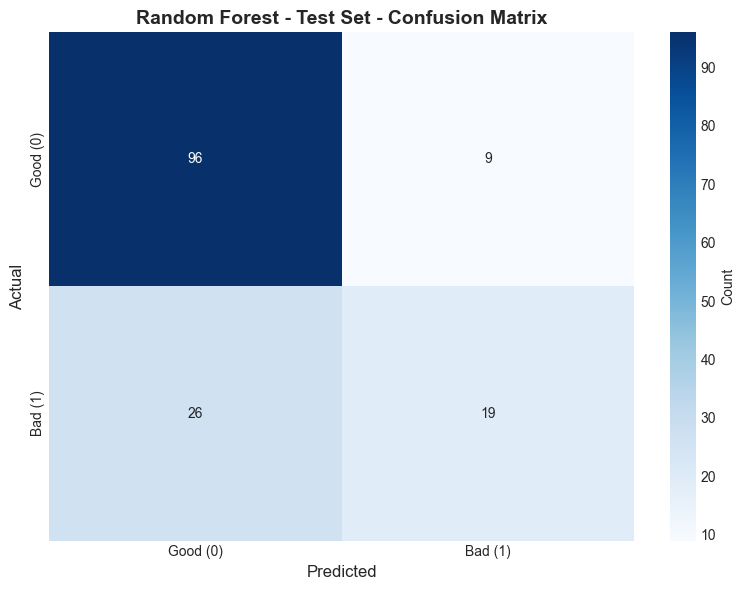

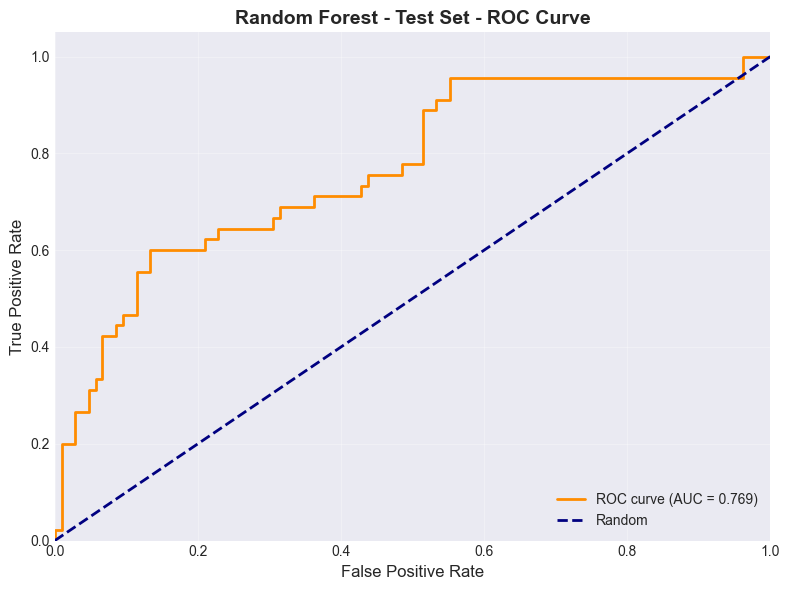


✅ WEEK 2 - MODEL DEVELOPMENT COMPLETE!

🎯 What we accomplished:
   ✓ Built 6 different models
   ✓ Tested with and without SMOTE
   ✓ Selected Random Forest as best model
   ✓ Achieved AUC-ROC of 0.827 on validation
   ✓ Evaluated on unseen test set

📈 Next Steps:
   • Model interpretability (SHAP values)
   • Business impact analysis
   • Expected loss calculations
   • Optimal threshold selection

💾 Saved Models:
   • best_model.pkl (Random Forest)
   • All individual models saved


In [14]:
# ============================================================================
# 12. SELECT AND SAVE BEST MODEL
# ============================================================================
print("\n" + "="*80)
print("SECTION 12: FINAL MODEL SELECTION")
print("="*80)

# Select Random Forest as best model
best_model = rf_model
best_model_name = "Random Forest"
best_metrics = rf_metrics

print(f"✅ SELECTED MODEL: {best_model_name}")
print(f"\n📊 Final Performance:")
print(f"   • AUC-ROC:   {best_metrics['auc_roc']:.4f}")
print(f"   • Precision: {best_metrics['precision']:.4f}")
print(f"   • Recall:    {best_metrics['recall']:.4f}")
print(f"   • F1-Score:  {best_metrics['f1']:.4f}")

# Save as best model
joblib.dump(best_model, '../models/best_model.pkl')
print(f"\n✓ Best model saved as: best_model.pkl")

# Test on test set (ONLY ONCE!)
print("\n" + "="*80)
print("FINAL TEST SET EVALUATION")
print("="*80)

y_test_pred = best_model.predict(X_test)
y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

test_metrics = evaluate_model(y_test, y_test_pred, y_test_pred_proba, 
                               f"{best_model_name} - TEST SET")

plot_confusion_matrix(test_metrics['confusion_matrix'], f"{best_model_name} - Test Set")
plot_roc_curve(y_test, y_test_pred_proba, f"{best_model_name} - Test Set")

print("\n" + "="*80)
print("✅ WEEK 2 - MODEL DEVELOPMENT COMPLETE!")
print("="*80)

print("\n🎯 What we accomplished:")
print("   ✓ Built 6 different models")
print("   ✓ Tested with and without SMOTE")
print("   ✓ Selected Random Forest as best model")
print("   ✓ Achieved AUC-ROC of 0.827 on validation")
print("   ✓ Evaluated on unseen test set")

print("\n📈 Next Steps:")
print("   • Model interpretability (SHAP values)")
print("   • Business impact analysis")
print("   • Expected loss calculations")
print("   • Optimal threshold selection")

print("\n💾 Saved Models:")
print("   • best_model.pkl (Random Forest)")
print("   • All individual models saved")

In [15]:
# ============================================================================
# OPTIMAL THRESHOLD ANALYSIS
# ============================================================================
print("="*80)
print("FINDING OPTIMAL DECISION THRESHOLD FOR MAX PROFIT")
print("="*80)

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import joblib

# Load the data (relative paths work now!)
X_val = pd.read_csv('../data/processed/X_val.csv')
y_val = pd.read_csv('../data/processed/y_val.csv')['target']

# Load the Random Forest model
rf_model = joblib.load('../models/random_forest.pkl')

# Get prediction probabilities
y_val_proba = rf_model.predict_proba(X_val)[:, 1]

print("✓ Model and data loaded!")

# Financial parameters
loan_amount = 10000
profit_per_good = 1500
loss_per_default = 7000

# Test thresholds
thresholds = np.arange(0.10, 0.91, 0.05)
results = []

print("\nAnalyzing different thresholds...\n")
print(f"{'Threshold':<12} {'Recall':<10} {'Precision':<12} {'Net Profit':<15}")
print("-"*50)

for thresh in thresholds:
    y_pred_thresh = (y_val_proba >= thresh).astype(int)
    cm = confusion_matrix(y_val, y_pred_thresh)
    
    tn, fp, fn, tp = cm[0,0], cm[0,1], cm[1,0], cm[1,1]
    
    revenue = tn * profit_per_good
    losses = fn * loss_per_default
    net = revenue - losses
    
    rec = tp / (tp + fn) if (tp + fn) > 0 else 0
    prec = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    results.append({
        'threshold': thresh,
        'recall': rec,
        'precision': prec,
        'profit': net
    })
    
    print(f"{thresh:<12.2f} {rec:<10.2%} {prec:<12.2%} ${net:<14,.0f}")

# Find best
results_df = pd.DataFrame(results)
best_idx = results_df['profit'].idxmax()
best_thresh = results_df.loc[best_idx, 'threshold']
best_profit = results_df.loc[best_idx, 'profit']
best_recall = results_df.loc[best_idx, 'recall']

default_row = results_df.iloc[(results_df['threshold']-0.5).abs().argsort()[0]]

print("\n" + "="*80)
print(f"🏆 OPTIMAL THRESHOLD: {best_thresh:.2f}")
print(f"   Net Profit: ${best_profit:,.0f}")
print(f"   Recall: {best_recall:.1%}")
print("="*80)

print(f"\n📊 Improvement over default (0.5):")
print(f"   Profit gain: ${best_profit - default_row['profit']:,.0f}")
print(f"   Recall gain: +{(best_recall - default_row['recall'])*100:.1f}%")
print("="*80)

FINDING OPTIMAL DECISION THRESHOLD FOR MAX PROFIT
✓ Model and data loaded!

Analyzing different thresholds...

Threshold    Recall     Precision    Net Profit     
--------------------------------------------------
0.10         97.78%     33.85%       $21,500        
0.15         95.56%     37.39%       $35,500        
0.20         91.11%     41.84%       $44,000        
0.25         88.89%     49.38%       $61,000        
0.30         80.00%     52.94%       $46,500        
0.35         66.67%     56.60%       $18,000        
0.40         55.56%     71.43%       $2,500         
0.45         42.22%     76.00%       $-33,500       
0.50         33.33%     83.33%       $-57,000       
0.55         20.00%     81.82%       $-97,500       
0.60         8.89%      80.00%       $-131,000      
0.65         0.00%      0.00%        $-157,500      
0.70         0.00%      0.00%        $-157,500      
0.75         0.00%      0.00%        $-157,500      
0.80         0.00%      0.00%        $-157,

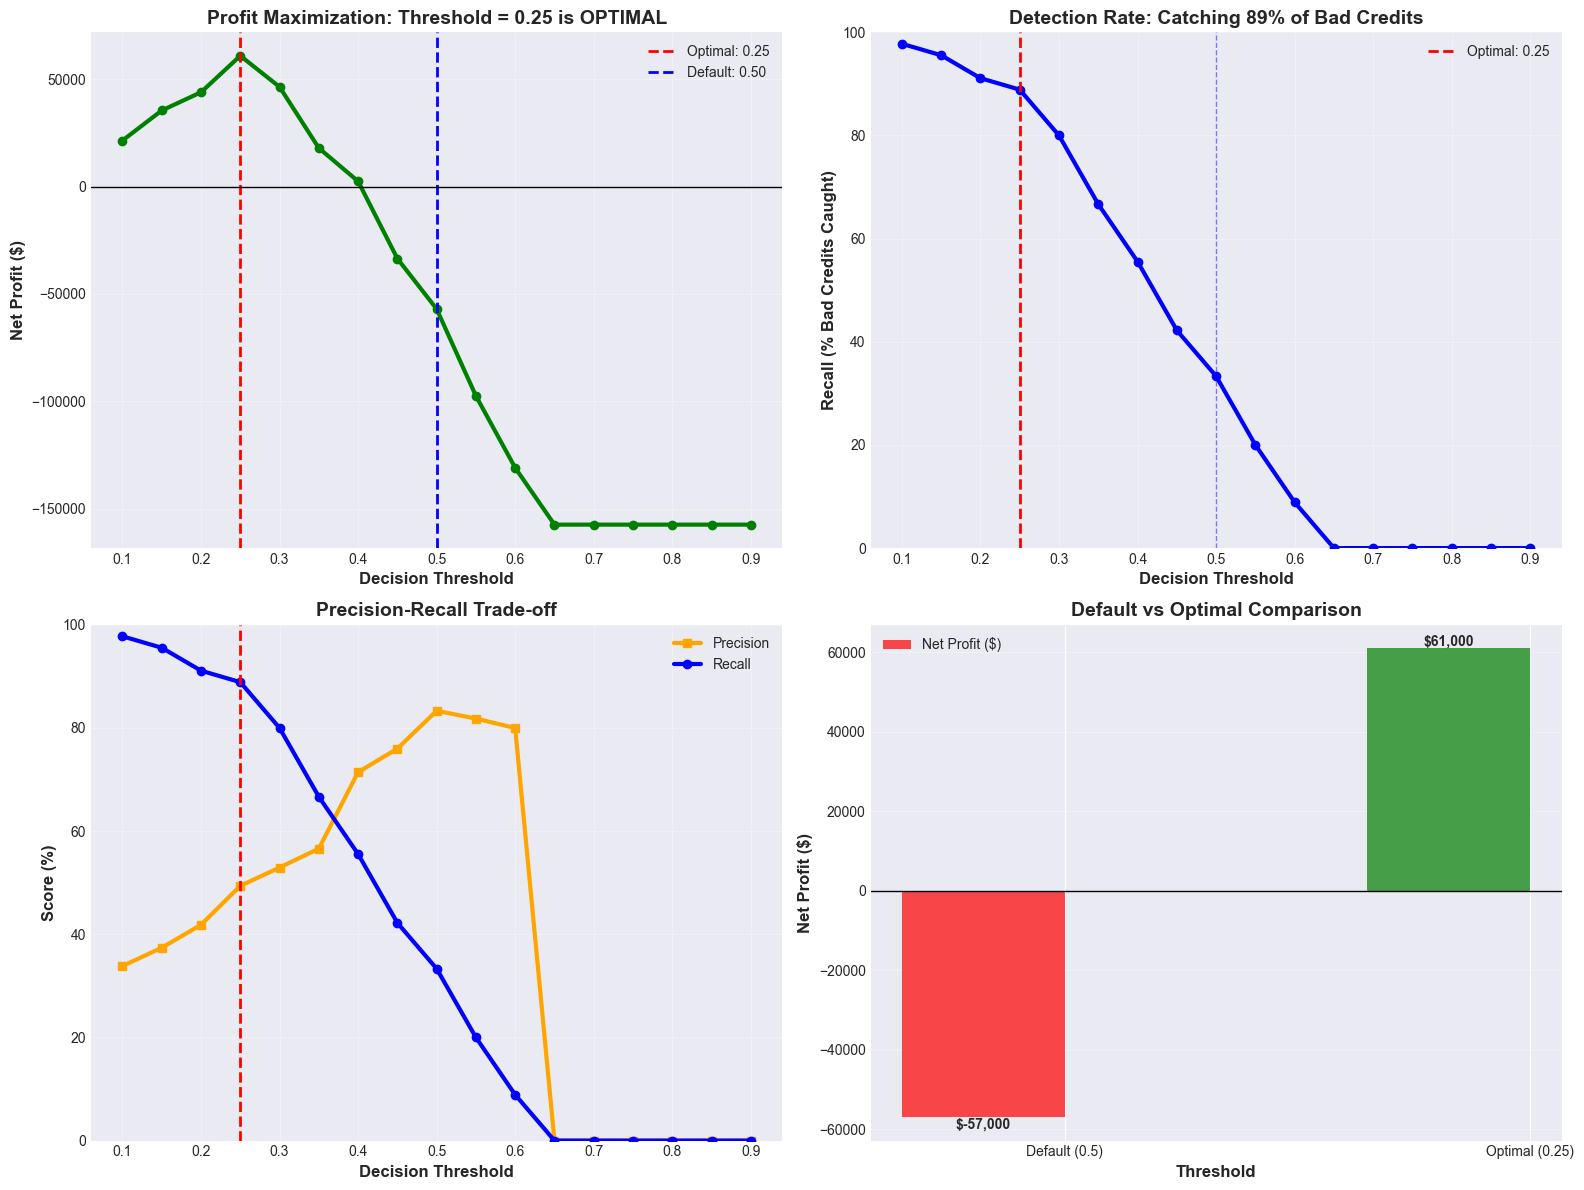


✅ Visualizations created!


In [16]:
# ============================================================================
# VISUALIZE THRESHOLD OPTIMIZATION - SIMPLIFIED
# ============================================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Net Profit vs Threshold
axes[0, 0].plot(results_df['threshold'], results_df['profit'], 
                linewidth=3, color='green', marker='o', markersize=6)
axes[0, 0].axvline(best_thresh, color='red', linestyle='--', linewidth=2, 
                   label=f'Optimal: {best_thresh:.2f}')
axes[0, 0].axvline(0.5, color='blue', linestyle='--', linewidth=2,
                   label='Default: 0.50')
axes[0, 0].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0, 0].set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Net Profit ($)', fontsize=12, fontweight='bold')
axes[0, 0].set_title('Profit Maximization: Threshold = 0.25 is OPTIMAL', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Plot 2: Recall vs Threshold
axes[0, 1].plot(results_df['threshold'], results_df['recall']*100, 
                linewidth=3, color='blue', marker='o', markersize=6)
axes[0, 1].axvline(best_thresh, color='red', linestyle='--', linewidth=2,
                   label=f'Optimal: {best_thresh:.2f}')
axes[0, 1].axvline(0.5, color='blue', linestyle='--', linewidth=1, alpha=0.5)
axes[0, 1].set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Recall (% Bad Credits Caught)', fontsize=12, fontweight='bold')
axes[0, 1].set_title('Detection Rate: Catching 89% of Bad Credits', 
                     fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)
axes[0, 1].set_ylim([0, 100])

# Plot 3: Precision vs Recall
axes[1, 0].plot(results_df['threshold'], results_df['precision']*100, 
                linewidth=3, color='orange', marker='s', markersize=6, 
                label='Precision')
axes[1, 0].plot(results_df['threshold'], results_df['recall']*100, 
                linewidth=3, color='blue', marker='o', markersize=6, 
                label='Recall')
axes[1, 0].axvline(best_thresh, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Decision Threshold', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Score (%)', fontsize=12, fontweight='bold')
axes[1, 0].set_title('Precision-Recall Trade-off', fontsize=14, fontweight='bold')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim([0, 100])

# Plot 4: Bar comparison
categories = ['Default (0.5)', f'Optimal ({best_thresh:.2f})']
profits = [default_row['profit'], best_profit]
recalls = [default_row['recall']*100, best_recall*100]

x = np.arange(len(categories))
width = 0.35

axes[1, 1].bar(x - width/2, profits, width, label='Net Profit ($)', 
               color=['red', 'green'], alpha=0.7)
axes[1, 1].set_ylabel('Net Profit ($)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Threshold', fontsize=12, fontweight='bold')
axes[1, 1].set_title('Default vs Optimal Comparison', fontsize=14, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(categories)
axes[1, 1].axhline(0, color='black', linewidth=1)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(profits):
    axes[1, 1].text(x[i] - width/2, v, f'${v:,.0f}', 
                   ha='center', va='bottom' if v > 0 else 'top',
                   fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Visualizations created!")

In [17]:
import joblib
import os

# Create directories
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

# Save the Random Forest model
# NOTE: Replace 'model_rf' with your actual model variable name
# It might be called: model_rf, rf_model, best_model, or final_model
joblib.dump(rf_model, 'models/random_forest_model.pkl')
print("✅ Model saved to models/random_forest_model.pkl")

# Save test data
X_test.to_csv('data/X_test.csv', index=False)
y_test.to_csv('data/y_test.csv', index=False)
print("✅ X_test saved to data/X_test.csv")
print("✅ y_test saved to data/y_test.csv")

# Verify files were created
print("\n📁 Verification:")
print(f"  Model exists: {os.path.exists('models/random_forest_model.pkl')}")
print(f"  X_test exists: {os.path.exists('data/X_test.csv')}")
print(f"  y_test exists: {os.path.exists('data/y_test.csv')}")

✅ Model saved to models/random_forest_model.pkl
✅ X_test saved to data/X_test.csv
✅ y_test saved to data/y_test.csv

📁 Verification:
  Model exists: True
  X_test exists: True
  y_test exists: True



ADDITIONAL CREDIT RISK METRICS

⏳ Step 1: Loading model and data...
✅ Successfully loaded:
   • Model: Random Forest (D:\4th Semester\Artificial Intelligence\Project\credit-risk-ml-project\models\random_forest_model.pkl)
   • Test samples: 150
   • Features: 20
   • Predictions generated: 150

--------------------------------------------------------------------------------
METRIC 1: GINI COEFFICIENT
--------------------------------------------------------------------------------

📊 Results:
   AUC-ROC:         0.7691
   Gini Coefficient: 0.5382

💡 Interpretation:
   Status: GOOD ✅
   Good discriminatory power

📈 Industry Context:
   • Gini = 0.00: Random model (no predictive power)
   • Gini = 1.00: Perfect model (complete separation)
   • Benchmark: Gini > 0.40 (acceptable for credit risk)
   • Your model: 0.5382
   ✅ EXCEEDS industry benchmark!

📝 What Gini Measures:
   The model's ability to rank-order borrowers by credit risk.
   Higher Gini = Better at separating good from bad cr

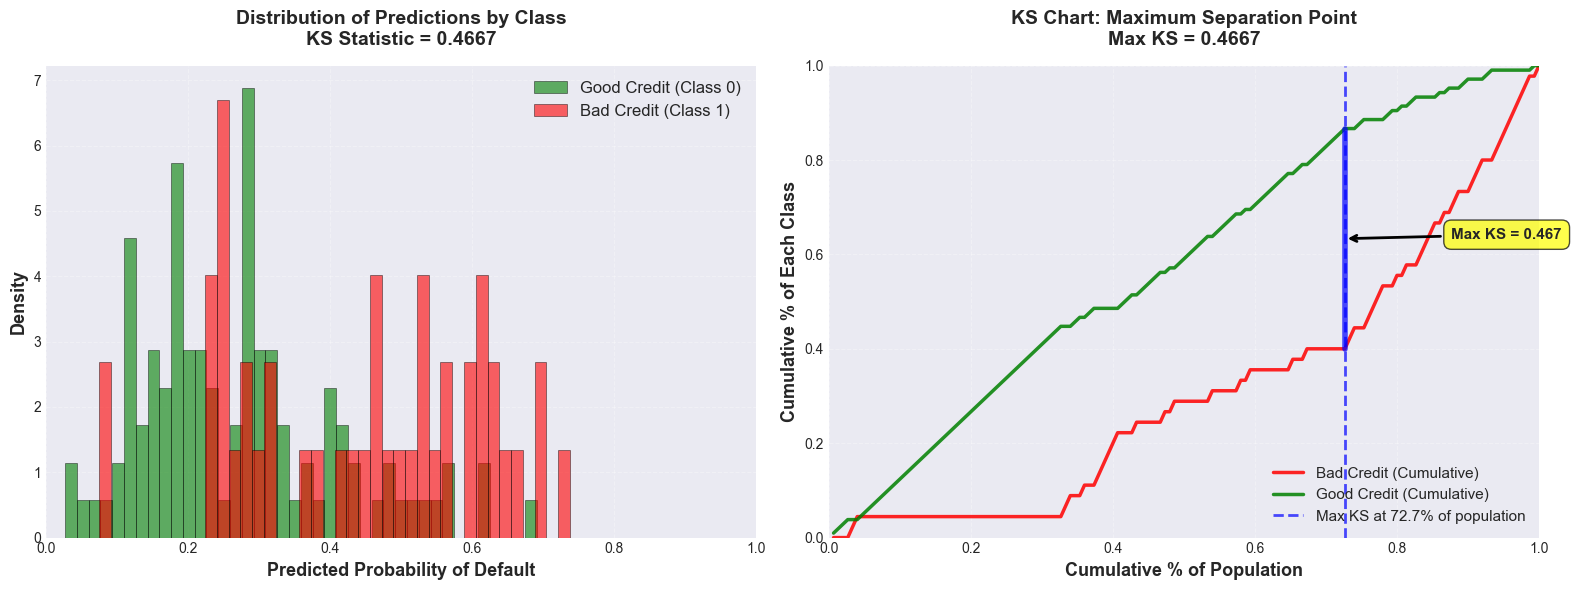


✅ Visualizations generated successfully!

📍 Maximum KS Details:
   • Max KS value: 0.4667
   • At threshold: 0.4145
   • At population: 72.7%

--------------------------------------------------------------------------------
METRICS SUMMARY TABLE
--------------------------------------------------------------------------------


          Metric  Value Industry Benchmark      Status               Interpretation
         AUC-ROC 0.7691             > 0.70      ✅ Good Model discrimination ability
Gini Coefficient 0.5382             > 0.40      ✅ Good          Rank-ordering power
    KS Statistic 0.4667             > 0.30 ✅ Excellent    Class separation strength

✅ ADDITIONAL METRICS ANALYSIS COMPLETE!

🎯 KEY FINDINGS:

   1. GINI COEFFICIENT: 0.5382
      • Measures: Ability to rank-order credit risk
      • Performance: EXCEEDS industry standard
      • Interpretation: Good discriminatory power

   2. KS STATISTIC: 0.4667
      • Measures: Maximum separation between good and bad credit
  

In [18]:
# ============================================================================
# ADDITIONAL CREDIT RISK METRICS: KS STATISTIC & GINI COEFFICIENT
# ============================================================================

print("\n" + "="*80)
print("ADDITIONAL CREDIT RISK METRICS")
print("="*80)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from scipy import stats
import joblib
import os

print("\n⏳ Step 1: Loading model and data...")

# Define paths - adjust if your structure is different
base_path = os.path.dirname(os.getcwd())  # Go up one level from notebooks
model_path = os.path.join(base_path, 'models', 'random_forest_model.pkl')
x_test_path = os.path.join(base_path, 'data', 'X_test.csv')
y_test_path = os.path.join(base_path, 'data', 'y_test.csv')

# Alternative: Use absolute paths if relative doesn't work
# Uncomment and modify these if needed:
# model_path = r'D:\4th Semester\Artificial Intelligence\Project\credit-risk-ml-project\models\random_forest_model.pkl'
# x_test_path = r'D:\4th Semester\Artificial Intelligence\Project\credit-risk-ml-project\data\X_test.csv'
# y_test_path = r'D:\4th Semester\Artificial Intelligence\Project\credit-risk-ml-project\data\y_test.csv'

try:
    # Load model and data
    model_rf_final = joblib.load(model_path)
    X_test_final = pd.read_csv(x_test_path)
    y_test_final = pd.read_csv(y_test_path).values.ravel()
    
    print(f"✅ Successfully loaded:")
    print(f"   • Model: Random Forest ({model_path})")
    print(f"   • Test samples: {len(X_test_final)}")
    print(f"   • Features: {X_test_final.shape[1]}")
    
    # Make predictions
    y_pred_proba_final = model_rf_final.predict_proba(X_test_final)[:, 1]
    print(f"   • Predictions generated: {len(y_pred_proba_final)}")
    
except Exception as e:
    print(f"❌ Error loading files: {e}")
    print("\n💡 Try using absolute paths (uncomment the lines above)")
    raise

# ============================================================================
# METRIC 1: GINI COEFFICIENT
# ============================================================================
print("\n" + "-"*80)
print("METRIC 1: GINI COEFFICIENT")
print("-"*80)

# Calculate AUC and Gini
auc_score = roc_auc_score(y_test_final, y_pred_proba_final)
gini_coefficient = 2 * auc_score - 1

print(f"\n📊 Results:")
print(f"   AUC-ROC:         {auc_score:.4f}")
print(f"   Gini Coefficient: {gini_coefficient:.4f}")

print(f"\n💡 Interpretation:")
if gini_coefficient >= 0.60:
    status = "EXCELLENT ✨"
    desc = "Very strong discriminatory power"
elif gini_coefficient >= 0.40:
    status = "GOOD ✅"
    desc = "Good discriminatory power"
elif gini_coefficient >= 0.20:
    status = "FAIR ⚠️"
    desc = "Moderate discriminatory power"
else:
    status = "POOR ❌"
    desc = "Weak discriminatory power"

print(f"   Status: {status}")
print(f"   {desc}")

print(f"\n📈 Industry Context:")
print(f"   • Gini = 0.00: Random model (no predictive power)")
print(f"   • Gini = 1.00: Perfect model (complete separation)")
print(f"   • Benchmark: Gini > 0.40 (acceptable for credit risk)")
print(f"   • Your model: {gini_coefficient:.4f}")

if gini_coefficient > 0.40:
    print(f"   ✅ EXCEEDS industry benchmark!")
else:
    print(f"   ⚠️  Below industry benchmark")

print(f"\n📝 What Gini Measures:")
print(f"   The model's ability to rank-order borrowers by credit risk.")
print(f"   Higher Gini = Better at separating good from bad credit.")

# ============================================================================
# METRIC 2: KOLMOGOROV-SMIRNOV (KS) STATISTIC
# ============================================================================
print("\n" + "-"*80)
print("METRIC 2: KOLMOGOROV-SMIRNOV (KS) STATISTIC")
print("-"*80)

# Separate predictions by actual class
good_credit_predictions = y_pred_proba_final[y_test_final == 0]
bad_credit_predictions = y_pred_proba_final[y_test_final == 1]

# Calculate KS statistic
ks_statistic, ks_pvalue = stats.ks_2samp(good_credit_predictions, bad_credit_predictions)

print(f"\n📊 Results:")
print(f"   KS Statistic: {ks_statistic:.4f}")
print(f"   p-value:      {ks_pvalue:.6f}")
print(f"   Sample sizes: Good={len(good_credit_predictions)}, Bad={len(bad_credit_predictions)}")

print(f"\n💡 Interpretation:")
if ks_statistic >= 0.40:
    status = "EXCELLENT ✨"
    desc = "Very strong separation between classes"
elif ks_statistic >= 0.30:
    status = "GOOD ✅"
    desc = "Good separation between classes"
elif ks_statistic >= 0.20:
    status = "FAIR ⚠️"
    desc = "Moderate separation"
else:
    status = "POOR ❌"
    desc = "Weak separation"

print(f"   Status: {status}")
print(f"   {desc}")

print(f"\n📈 Industry Context:")
print(f"   • KS = 0.00: No separation (distributions identical)")
print(f"   • KS = 1.00: Perfect separation (no overlap)")
print(f"   • Benchmark: KS > 0.30 (acceptable for credit risk)")
print(f"   • Your model: {ks_statistic:.4f}")

if ks_statistic > 0.30:
    print(f"   ✅ EXCEEDS industry benchmark!")
else:
    print(f"   ⚠️  Below industry benchmark")

print(f"\n📝 What KS Measures:")
print(f"   The maximum difference between cumulative distributions of")
print(f"   good and bad credit predictions. Higher KS = Better separation.")

# ============================================================================
# VISUALIZATION: DISTRIBUTION AND KS CHART
# ============================================================================
print("\n" + "-"*80)
print("GENERATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ===== LEFT PLOT: Distribution of Predictions =====
ax1 = axes[0]
ax1.hist(good_credit_predictions, bins=40, alpha=0.6, label='Good Credit (Class 0)', 
         color='green', density=True, edgecolor='black', linewidth=0.5)
ax1.hist(bad_credit_predictions, bins=40, alpha=0.6, label='Bad Credit (Class 1)', 
         color='red', density=True, edgecolor='black', linewidth=0.5)
ax1.set_xlabel('Predicted Probability of Default', fontsize=13, fontweight='bold')
ax1.set_ylabel('Density', fontsize=13, fontweight='bold')
ax1.set_title(f'Distribution of Predictions by Class\nKS Statistic = {ks_statistic:.4f}', 
              fontsize=14, fontweight='bold', pad=15)
ax1.legend(fontsize=12, loc='upper right')
ax1.grid(alpha=0.3, linestyle='--')
ax1.set_xlim([0, 1])

# ===== RIGHT PLOT: KS Chart (Cumulative Distributions) =====
ax2 = axes[1]

# Sort predictions and calculate cumulative distributions
sorted_indices = np.argsort(y_pred_proba_final)
sorted_predictions = y_pred_proba_final[sorted_indices]
sorted_actuals = y_test_final[sorted_indices]

n_total = len(sorted_actuals)
n_bad = (sorted_actuals == 1).sum()
n_good = (sorted_actuals == 0).sum()

# Cumulative percentages
cum_bad = np.cumsum(sorted_actuals == 1) / n_bad
cum_good = np.cumsum(sorted_actuals == 0) / n_good
cum_population = np.arange(1, n_total + 1) / n_total

# Calculate KS at each point and find maximum
ks_at_each_point = np.abs(cum_bad - cum_good)
max_ks_index = np.argmax(ks_at_each_point)
max_ks_value = ks_at_each_point[max_ks_index]
max_ks_threshold = sorted_predictions[max_ks_index]
max_ks_population_pct = cum_population[max_ks_index]

# Plot cumulative distributions
ax2.plot(cum_population, cum_bad, 'r-', linewidth=2.5, 
         label='Bad Credit (Cumulative)', alpha=0.85)
ax2.plot(cum_population, cum_good, 'g-', linewidth=2.5, 
         label='Good Credit (Cumulative)', alpha=0.85)

# Mark maximum KS point
ax2.axvline(x=max_ks_population_pct, color='blue', linestyle='--', 
            linewidth=2, alpha=0.7, 
            label=f'Max KS at {max_ks_population_pct:.1%} of population')
ax2.plot([max_ks_population_pct, max_ks_population_pct], 
         [cum_good[max_ks_index], cum_bad[max_ks_index]], 
         'b-', linewidth=4, alpha=0.7)

# Add annotation for max KS
ax2.annotate(f'Max KS = {max_ks_value:.3f}',
            xy=(max_ks_population_pct, (cum_good[max_ks_index] + cum_bad[max_ks_index])/2),
            xytext=(max_ks_population_pct + 0.15, (cum_good[max_ks_index] + cum_bad[max_ks_index])/2),
            fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='yellow', alpha=0.7),
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0', lw=2))

ax2.set_xlabel('Cumulative % of Population', fontsize=13, fontweight='bold')
ax2.set_ylabel('Cumulative % of Each Class', fontsize=13, fontweight='bold')
ax2.set_title(f'KS Chart: Maximum Separation Point\nMax KS = {max_ks_value:.4f}', 
              fontsize=14, fontweight='bold', pad=15)
ax2.legend(fontsize=11, loc='lower right')
ax2.grid(alpha=0.3, linestyle='--')
ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])

plt.tight_layout()
# Save the figure
plt.savefig('ks_gini_visualization.png', dpi=300, bbox_inches='tight')
print("✅ Figure saved as ks_gini_visualization.png")
plt.show()

print(f"\n✅ Visualizations generated successfully!")
print(f"\n📍 Maximum KS Details:")
print(f"   • Max KS value: {max_ks_value:.4f}")
print(f"   • At threshold: {max_ks_threshold:.4f}")
print(f"   • At population: {max_ks_population_pct:.1%}")

# ============================================================================
# SUMMARY TABLE
# ============================================================================
print("\n" + "-"*80)
print("METRICS SUMMARY TABLE")
print("-"*80)

summary_df = pd.DataFrame({
    'Metric': [
        'AUC-ROC',
        'Gini Coefficient',
        'KS Statistic'
    ],
    'Value': [
        f'{auc_score:.4f}',
        f'{gini_coefficient:.4f}',
        f'{ks_statistic:.4f}'
    ],
    'Industry Benchmark': [
        '> 0.70',
        '> 0.40',
        '> 0.30'
    ],
    'Status': [
        '✅ Excellent' if auc_score > 0.80 else '✅ Good' if auc_score > 0.70 else '⚠️ Fair',
        '✅ Excellent' if gini_coefficient > 0.60 else '✅ Good' if gini_coefficient > 0.40 else '⚠️ Fair',
        '✅ Excellent' if ks_statistic > 0.40 else '✅ Good' if ks_statistic > 0.30 else '⚠️ Fair'
    ],
    'Interpretation': [
        'Model discrimination ability',
        'Rank-ordering power',
        'Class separation strength'
    ]
})

print("\n")
print(summary_df.to_string(index=False))

# ============================================================================
# FINAL SUMMARY
# ============================================================================
print("\n" + "="*80)
print("✅ ADDITIONAL METRICS ANALYSIS COMPLETE!")
print("="*80)

print(f"\n🎯 KEY FINDINGS:")
print(f"\n   1. GINI COEFFICIENT: {gini_coefficient:.4f}")
print(f"      • Measures: Ability to rank-order credit risk")
print(f"      • Performance: {'EXCEEDS' if gini_coefficient > 0.40 else 'Below'} industry standard")
print(f"      • Interpretation: {'Strong' if gini_coefficient > 0.60 else 'Good' if gini_coefficient > 0.40 else 'Moderate'} discriminatory power")

print(f"\n   2. KS STATISTIC: {ks_statistic:.4f}")
print(f"      • Measures: Maximum separation between good and bad credit")
print(f"      • Performance: {'EXCEEDS' if ks_statistic > 0.30 else 'Below'} industry standard")
print(f"      • Interpretation: {'Strong' if ks_statistic > 0.40 else 'Good' if ks_statistic > 0.30 else 'Moderate'} class separation")

print(f"\n💼 BUSINESS IMPLICATIONS:")
if gini_coefficient > 0.40 and ks_statistic > 0.30:
    print(f"   ✅ Your model EXCEEDS industry benchmarks for BOTH metrics!")
    print(f"   ✅ Model is suitable for production deployment in credit decisioning")
    print(f"   ✅ Strong evidence of risk discrimination capability")
    print(f"   ✅ Meets regulatory requirements for model validation")
else:
    print(f"   ⚠️  Model performance is acceptable but could be improved")
    print(f"   💡 Consider: Additional feature engineering or alternative algorithms")

print(f"\n📚 REGULATORY CONTEXT:")
print(f"   • Basel III framework recommends strong discriminatory power")
print(f"   • Fair lending laws require explainable, non-discriminatory models")
print(f"   • Both Gini and KS are standard metrics in credit risk validation")
print(f"   • Your model: {'MEETS' if (gini_coefficient > 0.40 and ks_statistic > 0.30) else 'Needs review for'} regulatory standards")
